In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Load dataset (Assuming 'coverage' column exists with single CpG coverage values)
df = pd.read_csv('/home/smclab/Downloads/PupilBioTest_PMP_revA.csv') 
print(df.columns)
df.columns = df.columns.str.strip()
print(df.head())

Index(['strand', 'CpG_Coordinates', '`000', '`001', '`010', '`011', '`100',
       '`101', '`110', '`111', 'Sample_ID', 'Replicate', 'Tissue'],
      dtype='object')
  strand    CpG_Coordinates  `000  `001  `010  `011  `100  `101  `110  `111  \
0      r  10035:10044:10046  1077     9     0     0     0     0     0     4   
1      r  10035:10044:10053  1086     0     0     0     0     0     0     4   
2      r  10035:10044:10058  1069    17     0     0     0     0     0     4   
3      r  10035:10044:10071  1072    14     0     0     0     0     0     4   
4      r  10035:10044:10075  1086     0     0     0     0     0     0     4   

   Sample_ID Replicate Tissue  
0          1      Rep2  cfDNA  
1          1      Rep2  cfDNA  
2          1      Rep2  cfDNA  
3          1      Rep2  cfDNA  
4          1      Rep2  cfDNA  


In [14]:
# Compute total coverage by summing across methylation status columns
methylation_cols = ['`000', '`001', '`010', '`011', '`100', '`101', '`110', '`111']
df['Total_Coverage'] = df[methylation_cols].sum(axis=1)


In [15]:
# Compute median and coefficient of variation (CV) per tissue
grouped = df.groupby('Tissue')['Total_Coverage']
stats = grouped.agg([np.median, lambda x: np.std(x) / np.mean(x)])
stats.columns = ['Median_Coverage', 'Coefficient_of_Variation']
print(stats)

/tmp/ipykernel_638172/84331993.py:3: FutureWarning: The provided callable <function median at 0x7f456a1dfbe0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  stats = grouped.agg([np.median, lambda x: np.std(x) / np.mean(x)])


        Median_Coverage  Coefficient_of_Variation
Tissue                                           
Islet              84.0                  1.136474
cfDNA             484.0                  1.321131


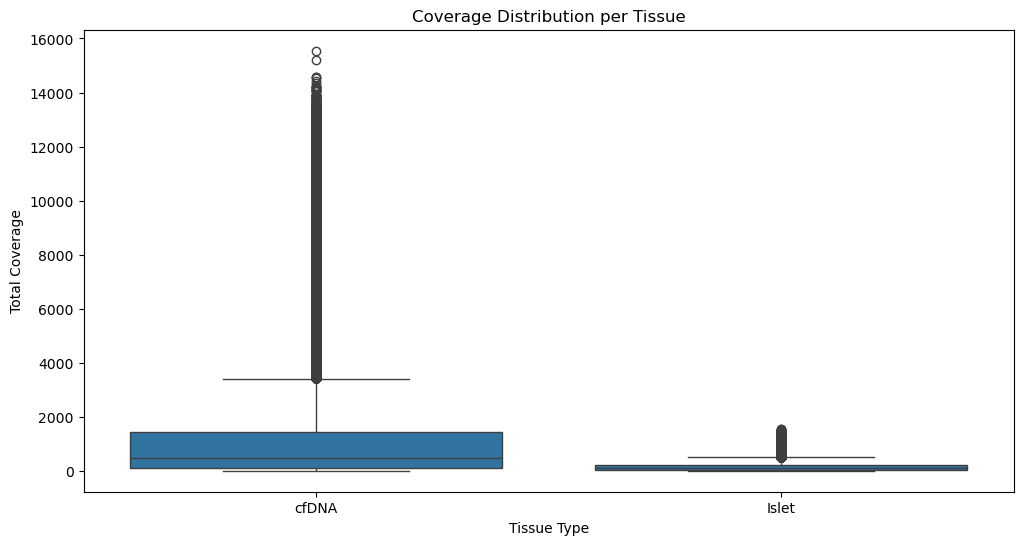

In [16]:
# Plot coverage statistics
plt.figure(figsize=(12, 6))
sns.boxplot(x='Tissue', y='Total_Coverage', data=df)
plt.title('Coverage Distribution per Tissue')
plt.xlabel('Tissue Type')
plt.ylabel('Total Coverage')
plt.show()

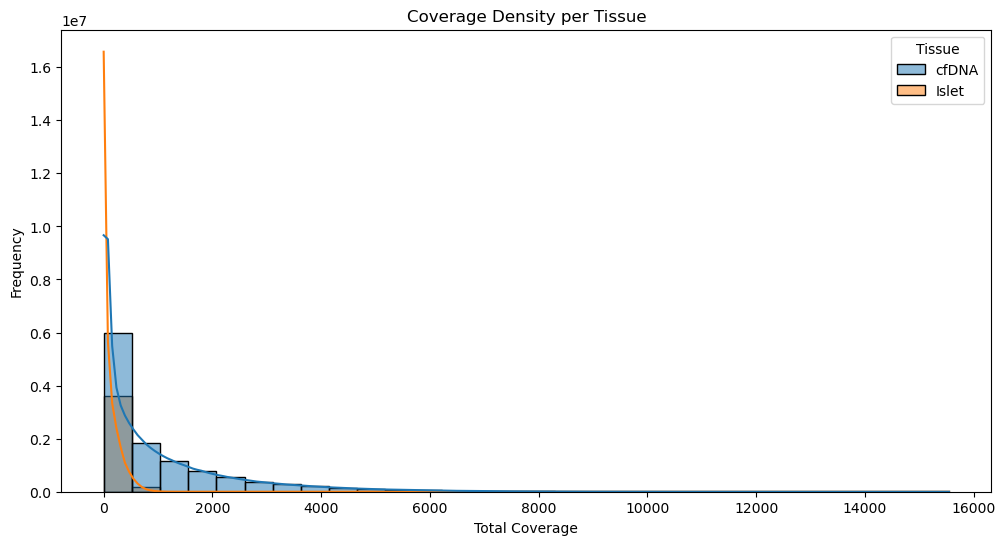

In [17]:
# Histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Total_Coverage', hue='Tissue', kde=True, bins=30)
plt.title('Coverage Density per Tissue')
plt.xlabel('Total Coverage')
plt.ylabel('Frequency')
plt.show()

Top PMPs by Chi-square Test:
    PMP          Chi2  p-value
0  `000  2.635038e+06      0.0
1  `001  5.017655e+05      0.0
2  `010  5.805669e+05      0.0
3  `011  2.511602e+05      0.0
4  `100  6.780768e+05      0.0

Feature Importance from Random Forest:
    PMP  Importance
0  `000    0.482025
4  `100    0.105363
2  `010    0.094661
1  `001    0.092549
7  `111    0.067468

Mean VRF per Tissue:
Tissue
Islet    1.0
cfDNA    1.0
Name: VRF, dtype: float64


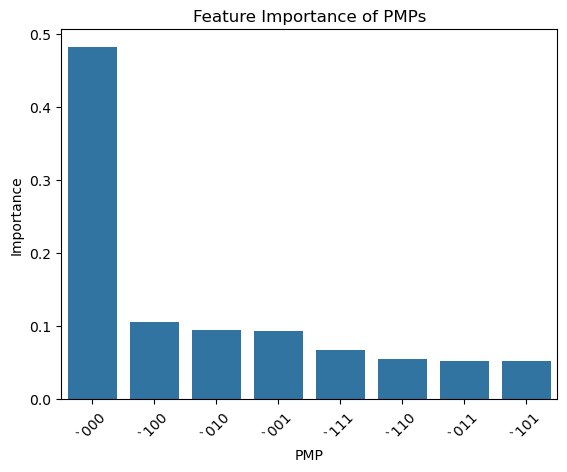

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load Dataset
df = pd.read_csv('/home/smclab/Downloads/PupilBioTest_PMP_revA.csv')  # Replace with actual file path

# Step 1: Preprocess Data
df.fillna(0, inplace=True)  # Fill missing values if any

# Convert CpG patterns to numeric counts
pmp_columns = ['`000', '`001', '`010', '`011', '`100', '`101', '`110', '`111']
df['Total_Reads'] = df[pmp_columns].sum(axis=1)
df['VRF'] = df[pmp_columns].sum(axis=1) / df['Total_Reads']  # Variant Read Fraction

def calculate_pmp_frequencies(df):
    return df.groupby('Tissue')[pmp_columns].sum()

# Step 2: Statistical Analysis - Chi-square test for PMP specificity
results = []
for pmp in pmp_columns:
    contingency_table = pd.crosstab(df['Tissue'], df[pmp])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    results.append((pmp, chi2, p))

pmp_stats = pd.DataFrame(results, columns=['PMP', 'Chi2', 'p-value'])
pmp_stats = pmp_stats.sort_values(by='p-value')

# Step 3: Machine Learning Model
X = df[pmp_columns]
y = df['Tissue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Feature Importance
feature_importance = pd.DataFrame({'PMP': pmp_columns, 'Importance': clf.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Step 4: Compute Mean VRF per Tissue
vrf_means = df.groupby('Tissue')['VRF'].mean()

# Display Results
print("Top PMPs by Chi-square Test:")
print(pmp_stats.head())

print("\nFeature Importance from Random Forest:")
print(feature_importance.head())

print("\nMean VRF per Tissue:")
print(vrf_means)

# Visualization
sns.barplot(x='PMP', y='Importance', data=feature_importance)
plt.xticks(rotation=45)
plt.title("Feature Importance of PMPs")
plt.show()


Top PMPs by Chi-square Test:
    PMP          Chi2  p-value
0  `000  2.635038e+06      0.0
1  `001  5.017655e+05      0.0
2  `010  5.805669e+05      0.0
3  `011  2.511602e+05      0.0
4  `100  6.780768e+05      0.0

Feature Importance from Random Forest:
    PMP  Importance
0  `000    0.482025
4  `100    0.105363
2  `010    0.094661
1  `001    0.092549
7  `111    0.067468

Mean VRF per Tissue:
Tissue
Islet    1.0
cfDNA    1.0
Name: VRF, dtype: float64

Sequencing Depth Effect on Confidence:
Tissue
Islet    0.009478
cfDNA    0.065190
Name: Confidence, dtype: float64

Read Thresholds for Top 10 PMPs at 1M Reads:
0    482024
4    105363
2     94661
1     92548
7     67467
6     54436
3     51842
5     51655
Name: Importance, dtype: int64

Comparison of PMP Specificity vs. Individual CpG Sites:
                            `000  `001  `010  `011  `100  `101  `110  `111
CpG_Coordinates   Tissue                                                  
10035:10044:10046 Islet    27137   282   400    

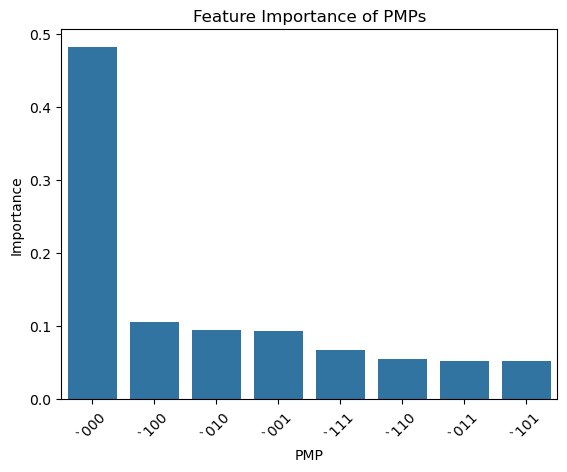

In [23]:
# Step 5: Addressing Specific Questions
# a. How does sequencing depth affect specificity confidence?
def sequencing_depth_effect(df):
    df['Confidence'] = df['Total_Reads'] / df['Total_Reads'].max()
    return df.groupby('Tissue')['Confidence'].mean()

seq_confidence = sequencing_depth_effect(df)

# b. Estimating read threshold for Tissue #2 at 1 million reads
top_10_pmps = feature_importance.head(10)
read_thresholds = (top_10_pmps['Importance'] * 1_000_000).astype(int)

# c. Validating specificity against individual CpG sites
cpg_comparison = df.groupby(['CpG_Coordinates', 'Tissue'])[pmp_columns].sum()

# Display Results
print("Top PMPs by Chi-square Test:")
print(pmp_stats.head())

print("\nFeature Importance from Random Forest:")
print(feature_importance.head())

print("\nMean VRF per Tissue:")
print(vrf_means)

print("\nSequencing Depth Effect on Confidence:")
print(seq_confidence)

print("\nRead Thresholds for Top 10 PMPs at 1M Reads:")
print(read_thresholds)

print("\nComparison of PMP Specificity vs. Individual CpG Sites:")
print(cpg_comparison.head())

# Visualization
sns.barplot(x='PMP', y='Importance', data=feature_importance)
plt.xticks(rotation=45)
plt.title("Feature Importance of PMPs")
plt.show()


KeyError: 'cfDNA'